In [1]:
import gc
import pickle
import numpy as np 
import pandas as pd 
from scipy.signal import medfilt
from category_encoders.ordinal import OrdinalEncoder
import matplotlib.pyplot as plt
from tsforest.utils import make_time_range
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***
## data loading

In [2]:
sales_train = pd.read_csv("../input/sales_train_evaluation.csv")
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [3]:
calendar = pd.read_csv("../input/calendar.csv", parse_dates=["date"])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    object        
 8   event_type_1  162 non-null    object        
 9   event_name_2  5 non-null      object        
 10  event_type_2  5 non-null      object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB


In [4]:
sell_prices = pd.read_csv("../input/sell_prices.csv")
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


***
### Events features

In [5]:
us_holidays = holidays.UnitedStates(years=[2011,2012,2013,2014,2015,2016], observed=True)
holidays_dataframe = pd.DataFrame(us_holidays.items(), columns=["ds","event"])
holidays_dataframe.sort_values("ds", inplace=True)

***
### long weekends features

In [6]:
lw_features = make_time_range("2011-01-29", "2016-06-19", "D")
lw_features.set_index("ds", inplace=True)
lw_features["lw_type"] = 0
lw_features["lw_day"] = 0
lw_features["prev_lw"] = 0
lw_features["post_lw"] = 0

In [7]:
# 2011-02-19 al 2011-02-21
lw_features.loc['2011-02-18', 'prev_lw'] = 1
lw_features.loc['2011-02-19':'2011-02-21', 'lw_type'] = 1
lw_features.loc['2011-02-19':'2011-02-21', 'lw_day'] = [1,2,3]
lw_features.loc['2011-02-22', 'post_lw'] = 1

# 2011-05-28 al 2011-05-30
lw_features.loc['2011-05-27', 'prev_lw'] = 1
lw_features.loc['2011-05-28':'2011-05-30', 'lw_type'] = 1
lw_features.loc['2011-05-28':'2011-05-30', 'lw_day'] = [1,2,3]
lw_features.loc['2011-05-31', 'post_lw'] = 1

# 2011-07-02 al 2011-07-04
lw_features.loc['2011-07-01', 'prev_lw'] = 1
lw_features.loc['2011-07-02':'2011-07-04', 'lw_type'] = 1
lw_features.loc['2011-07-02':'2011-07-04', 'lw_day'] = [1,2,3]
lw_features.loc['2011-07-05', 'post_lw'] = 1

# 2011-09-03 al 2011-09-05
lw_features.loc['2011-09-02', 'prev_lw'] = 1
lw_features.loc['2011-09-03':'2011-09-05', 'lw_type'] = 1
lw_features.loc['2011-09-03':'2011-09-05', 'lw_day'] = [1,2,3]
lw_features.loc['2011-09-06', 'post_lw'] = 1

# 2011-10-08 al 2011-10-10
lw_features.loc['2011-10-07', 'prev_lw'] = 1
lw_features.loc['2011-10-08':'2011-10-10', 'lw_type'] = 1
lw_features.loc['2011-10-08':'2011-10-10', 'lw_day'] = [1,2,3]
lw_features.loc['2011-10-11', 'post_lw'] = 1

# 2011-11-11 al 2011-11-13
lw_features.loc['2011-11-10', 'prev_lw'] = 1
lw_features.loc['2011-11-11':'2011-11-13', 'lw_type'] = 2
lw_features.loc['2011-11-11':'2011-11-13', 'lw_day'] = [1,2,3]
lw_features.loc['2011-11-14', 'post_lw'] = 1

# 2011-12-24 al 2011-12-26
lw_features.loc['2011-12-23', 'prev_lw'] = 1
lw_features.loc['2011-12-24':'2011-12-26', 'lw_type'] = 1
lw_features.loc['2011-12-24':'2011-12-26', 'lw_day'] = [1,2,3]
lw_features.loc['2011-12-27', 'post_lw'] = 1

# 2011-12-31 al 2012-01-02
lw_features.loc['2011-12-30', 'prev_lw'] = 1
lw_features.loc['2011-12-31':'2012-01-02', 'lw_type'] = 1
lw_features.loc['2011-12-31':'2012-01-02', 'lw_day'] = [1,2,3]
lw_features.loc['2012-01-03', 'post_lw'] = 1

# 2012-01-14 al 2012-01-16
lw_features.loc['2012-01-13', 'prev_lw'] = 1
lw_features.loc['2012-01-14':'2012-01-16', 'lw_type'] = 1
lw_features.loc['2012-01-14':'2012-01-16', 'lw_day'] = [1,2,3]
lw_features.loc['2012-01-17', 'post_lw'] = 1

# 2012-02-18 al 2012-02-20
lw_features.loc['2012-02-17', 'prev_lw'] = 1
lw_features.loc['2012-02-18':'2012-02-20', 'lw_type'] = 1
lw_features.loc['2012-02-18':'2012-02-20', 'lw_day'] = [1,2,3]
lw_features.loc['2012-02-21', 'post_lw'] = 1

# 2012-05-26 al 2012-05-28
lw_features.loc['2012-05-25', 'prev_lw'] = 1
lw_features.loc['2012-05-26':'2012-05-28', 'lw_type'] = 1
lw_features.loc['2012-05-26':'2012-05-28', 'lw_day'] = [1,2,3]
lw_features.loc['2012-05-29', 'post_lw'] = 1

# 2012-09-01 al 2012-09-03
lw_features.loc['2012-08-31', 'prev_lw'] = 1
lw_features.loc['2012-09-01':'2012-09-03', 'lw_type'] = 1
lw_features.loc['2012-09-01':'2012-09-03', 'lw_day'] = [1,2,3]
lw_features.loc['2012-09-04', 'post_lw'] = 1

# 2012-10-06 al 2012-10-08
lw_features.loc['2012-10-05', 'prev_lw'] = 1
lw_features.loc['2012-10-06':'2012-10-08', 'lw_type'] = 1
lw_features.loc['2012-10-06':'2012-10-08', 'lw_day'] = [1,2,3]
lw_features.loc['2012-10-09', 'post_lw'] = 1

# 2013-01-19 al 2013-01-21
lw_features.loc['2013-01-18', 'prev_lw'] = 1
lw_features.loc['2013-01-19':'2013-01-21', 'lw_type'] = 1
lw_features.loc['2013-01-19':'2013-01-21', 'lw_day'] = [1,2,3]
lw_features.loc['2013-01-22', 'post_lw'] = 1

# 2013-02-16 al 2013-02-18
lw_features.loc['2013-02-15', 'prev_lw'] = 1
lw_features.loc['2013-02-16':'2013-02-18', 'lw_type'] = 1
lw_features.loc['2013-02-16':'2013-02-18', 'lw_day'] = [1,2,3]
lw_features.loc['2013-02-19', 'post_lw'] = 1

# 2013-05-25 al 2013-05-27
lw_features.loc['2013-05-24', 'prev_lw'] = 1
lw_features.loc['2013-05-25':'2013-05-27', 'lw_type'] = 1
lw_features.loc['2013-05-25':'2013-05-27', 'lw_day'] = [1,2,3]
lw_features.loc['2013-05-28', 'post_lw'] = 1

# 2013-08-31 al 2013-09-02
lw_features.loc['2013-08-30', 'prev_lw'] = 1
lw_features.loc['2013-08-31':'2013-09-02', 'lw_type'] = 1
lw_features.loc['2013-08-31':'2013-09-02', 'lw_day'] = [1,2,3]
lw_features.loc['2013-09-03', 'post_lw'] = 1

# 2013-10-12 al 2013-10-14
lw_features.loc['2013-10-11', 'prev_lw'] = 1
lw_features.loc['2013-10-12':'2013-10-14', 'lw_type'] = 1
lw_features.loc['2013-10-12':'2013-10-14', 'lw_day'] = [1,2,3]
lw_features.loc['2013-10-15', 'post_lw'] = 1

# 2013-11-09 al 2013-11-11
lw_features.loc['2013-11-08', 'prev_lw'] = 1
lw_features.loc['2013-11-09':'2013-11-11', 'lw_type'] = 1
lw_features.loc['2013-11-09':'2013-11-11', 'lw_day'] = [1,2,3]
lw_features.loc['2013-11-12', 'post_lw'] = 1

# 2014-01-18 al 2014-01-20
lw_features.loc['2014-01-17', 'prev_lw'] = 1
lw_features.loc['2014-01-18':'2014-01-20', 'lw_type'] = 1
lw_features.loc['2014-01-18':'2014-01-20', 'lw_day'] = [1,2,3]
lw_features.loc['2014-01-21', 'post_lw'] = 1

# 2014-02-15 al 2014-02-17
lw_features.loc['2014-02-14', 'prev_lw'] = 1
lw_features.loc['2014-02-15':'2014-02-17', 'lw_type'] = 1
lw_features.loc['2014-02-15':'2014-02-17', 'lw_day'] = [1,2,3]
lw_features.loc['2014-02-18', 'post_lw'] = 1

# 2014-05-24 al 2014-05-26
lw_features.loc['2014-05-23', 'prev_lw'] = 1
lw_features.loc['2014-05-24':'2014-05-26', 'lw_type'] = 1
lw_features.loc['2014-05-24':'2014-05-26', 'lw_day'] = [1,2,3]
lw_features.loc['2014-05-27', 'post_lw'] = 1

# 2014-07-04 al 2014-07-06
lw_features.loc['2014-07-03', 'prev_lw'] = 1
lw_features.loc['2014-07-04':'2014-07-06', 'lw_type'] = 2
lw_features.loc['2014-07-04':'2014-07-06', 'lw_day'] = [1,2,3]
lw_features.loc['2014-07-07', 'post_lw'] = 1

# 2014-08-30 al 2014-09-01
lw_features.loc['2014-08-29', 'prev_lw'] = 1
lw_features.loc['2014-08-30':'2014-09-01', 'lw_type'] = 1
lw_features.loc['2014-08-30':'2014-09-01', 'lw_day'] = [1,2,3]
lw_features.loc['2014-09-02', 'post_lw'] = 1

# 2014-10-11 al 2014-10-13
lw_features.loc['2014-10-10', 'prev_lw'] = 1
lw_features.loc['2014-10-11':'2014-10-13', 'lw_type'] = 1
lw_features.loc['2014-10-11':'2014-10-13', 'lw_day'] = [1,2,3]
lw_features.loc['2014-10-14', 'post_lw'] = 1

# 2015-01-17 al 2015-01-19
lw_features.loc['2015-01-16', 'prev_lw'] = 1
lw_features.loc['2015-01-17':'2015-01-19', 'lw_type'] = 1
lw_features.loc['2015-01-17':'2015-01-19', 'lw_day'] = [1,2,3]
lw_features.loc['2015-01-20', 'post_lw'] = 1

# 2015-02-14 al 2015-02-16
lw_features.loc['2015-02-13', 'prev_lw'] = 1
lw_features.loc['2015-02-14':'2015-02-16', 'lw_type'] = 1
lw_features.loc['2015-02-14':'2015-02-16', 'lw_day'] = [1,2,3]
lw_features.loc['2015-02-17', 'post_lw'] = 1

# 2015-05-23 al 2015-05-25
lw_features.loc['2015-05-22', 'prev_lw'] = 1
lw_features.loc['2015-05-23':'2015-05-25', 'lw_type'] = 1
lw_features.loc['2015-05-23':'2015-05-25', 'lw_day'] = [1,2,3]
lw_features.loc['2015-05-26', 'post_lw'] = 1

# 2015-07-03 al 2015-07-05
lw_features.loc['2015-07-02', 'prev_lw'] = 1
lw_features.loc['2015-07-03':'2015-07-05', 'lw_type'] = 2
lw_features.loc['2015-07-03':'2015-07-05', 'lw_day'] = [1,2,3]
lw_features.loc['2015-07-06', 'post_lw'] = 1

# 2015-09-05 al 2015-09-07
lw_features.loc['2015-09-04', 'prev_lw'] = 1
lw_features.loc['2015-09-05':'2015-09-07', 'lw_type'] = 1
lw_features.loc['2015-09-05':'2015-09-07', 'lw_day'] = [1,2,3]
lw_features.loc['2015-09-08', 'post_lw'] = 1

# 2015-10-10 al 2015-10-12
lw_features.loc['2015-10-09', 'prev_lw'] = 1
lw_features.loc['2015-10-10':'2015-10-12', 'lw_type'] = 1
lw_features.loc['2015-10-10':'2015-10-12', 'lw_day'] = [1,2,3]
lw_features.loc['2015-10-13', 'post_lw'] = 1

# 2015-12-25 al 2015-12-27
lw_features.loc['2015-12-24', 'prev_lw'] = 1
lw_features.loc['2015-12-25':'2015-12-27', 'lw_type'] = 2
lw_features.loc['2015-12-25':'2015-12-27', 'lw_day'] = [1,2,3]
lw_features.loc['2015-12-28', 'post_lw'] = 1

# 2016-01-01 al 2016-01-03
lw_features.loc['2015-12-31', 'prev_lw'] = 1
lw_features.loc['2016-01-01':'2016-01-03', 'lw_type'] = 2
lw_features.loc['2016-01-01':'2016-01-03', 'lw_day'] = [1,2,3]
lw_features.loc['2016-01-04', 'post_lw'] = 1

# 2016-01-16 al 2016-01-18
lw_features.loc['2016-01-15', 'prev_lw'] = 1
lw_features.loc['2016-01-16':'2016-01-18', 'lw_type'] = 1
lw_features.loc['2016-01-16':'2016-01-18', 'lw_day'] = [1,2,3]
lw_features.loc['2016-01-19', 'post_lw'] = 1

# 2016-02-13 al 2016-02-15
lw_features.loc['2016-02-12', 'prev_lw'] = 1
lw_features.loc['2016-02-13':'2016-02-15', 'lw_type'] = 1
lw_features.loc['2016-02-13':'2016-02-15', 'lw_day'] = [1,2,3]
lw_features.loc['2016-02-16', 'post_lw'] = 1

# 2016-05-28 al 2016-05-30
lw_features.loc['2016-05-27', 'prev_lw'] = 1
lw_features.loc['2016-05-28':'2016-05-30', 'lw_type'] = 1
lw_features.loc['2016-05-28':'2016-05-30', 'lw_day'] = [1,2,3]
lw_features.loc['2016-05-31', 'post_lw'] = 1


In [8]:
lw_features.reset_index(inplace=True)

In [9]:
lw_features = reduce_mem_usage(lw_features)
gc.collect()

44

***
### events features

In [10]:
events_features = make_time_range("2011-01-29", "2016-06-19", "D")

In [11]:
# christmas features
events_features["prev_christmas"] = 0
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 20").index, "prev_christmas"] = 1
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 21").index, "prev_christmas"] = 2
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 22").index, "prev_christmas"] = 3
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 23").index, "prev_christmas"] = 4
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 24").index, "prev_christmas"] = 5
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 25").index, "prev_christmas"] = 6

events_features["post_christmas"] = 0
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 26").index, "post_christmas"] = 1

In [12]:
# new year features
events_features["prev_newyear"] = 0
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 28").index, "prev_newyear"] = 1
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 29").index, "prev_newyear"] = 2
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 30").index, "prev_newyear"] = 3
events_features.loc[events_features.query("ds.dt.month == 12 & ds.dt.day == 31").index, "prev_newyear"] = 4

events_features["post_newyear"] = 0
events_features.loc[events_features.query("ds.dt.month == 1 & ds.dt.day == 1").index, "post_newyear"] = 1

In [13]:
# Thanksgiving features
events_features["prev_thanksgiving"] = 0
events_features["post_thanksgiving"] = 0

idx = events_features.query("ds.dt.year == 2011 & ds.dt.month == 11 & ds.dt.day in [22,23,24]").index
events_features.loc[idx, "prev_thanksgiving"] = [1,2,3]
idx = events_features.query("ds.dt.year == 2011 & ds.dt.month == 11 & ds.dt.day == 25").index
events_features.loc[idx, "post_thanksgiving"] = 1

idx = events_features.query("ds.dt.year == 2012 & ds.dt.month == 11 & ds.dt.day in [20,21,22]").index
events_features.loc[idx, "prev_thanksgiving"] = [1,2,3]
idx = events_features.query("ds.dt.year == 2012 & ds.dt.month == 11 & ds.dt.day == 23").index
events_features.loc[idx, "post_thanksgiving"] = 1

idx = events_features.query("ds.dt.year == 2013 & ds.dt.month == 11 & ds.dt.day in [26,27,28]").index
events_features.loc[idx, "prev_thanksgiving"] = [1,2,3]
idx = events_features.query("ds.dt.year == 2013 & ds.dt.month == 11 & ds.dt.day == 29").index
events_features.loc[idx, "post_thanksgiving"] = 1

idx = events_features.query("ds.dt.year == 2014 & ds.dt.month == 11 & ds.dt.day in [25,26,27]").index
events_features.loc[idx, "prev_thanksgiving"] = [1,2,3]
idx = events_features.query("ds.dt.year == 2014 & ds.dt.month == 11 & ds.dt.day == 28").index
events_features.loc[idx, "post_thanksgiving"] = 1

idx = events_features.query("ds.dt.year == 2015 & ds.dt.month == 11 & ds.dt.day in [24,25,26]").index
events_features.loc[idx, "prev_thanksgiving"] = [1,2,3]
idx = events_features.query("ds.dt.year == 2015 & ds.dt.month == 11 & ds.dt.day == 27").index
events_features.loc[idx, "post_thanksgiving"] = 1

In [14]:
events_features = reduce_mem_usage(events_features)
gc.collect()

173

***
## extra snap features

In [15]:
calendar["week"] = calendar.date.dt.weekofyear
cumulative_snap = calendar.groupby(["year","month","week"])[["snap_CA", "snap_WI", "snap_TX"]].cumsum()
cumulative_snap.columns = [f"{col}_cum" for col in cumulative_snap.columns]
calendar.drop("week", axis=1, inplace=True)
for column in cumulative_snap.columns:
    calendar[column] = cumulative_snap[column]

***
## hierarchy

In [16]:
sales_train["id"] = sales_train.id.map(lambda x: x.replace("_evaluation", ""))
hierarchy = (sales_train.loc[:, ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]]
             .drop_duplicates())
encoders = dict()

In [17]:
hierarchy.to_parquet("../input/hierarchy_raw.parquet", index=False)

In [18]:
# hierarchy encoder
id_encoder = OrdinalEncoder()
id_encoder.fit(hierarchy.loc[:, ["id"]])
hierarchy["ts_id"]  = id_encoder.transform(hierarchy.loc[:, ["id"]])
encoders["id"] = id_encoder

item_encoder = OrdinalEncoder()
item_encoder.fit(hierarchy.loc[:, ["item_id"]])
hierarchy.loc[:, "item_id"]  = item_encoder.transform(hierarchy.loc[:, ["item_id"]])
encoders["item"] = item_encoder

dept_encoder = OrdinalEncoder()
dept_encoder.fit(hierarchy.loc[:, ["dept_id"]])
hierarchy.loc[:, "dept_id"]  = dept_encoder.transform(hierarchy.loc[:, ["dept_id"]])
encoders["dept"] = dept_encoder

cat_encoder = OrdinalEncoder()
cat_encoder.fit(hierarchy.loc[:, ["cat_id"]])
hierarchy.loc[:, "cat_id"]   = cat_encoder.transform(hierarchy.loc[:, ["cat_id"]])
encoders["cat"] = cat_encoder

store_encoder = OrdinalEncoder()
store_encoder.fit(hierarchy.loc[:, ["store_id"]])
hierarchy.loc[:, "store_id"] = store_encoder.transform(hierarchy.loc[:, ["store_id"]])
encoders["store"] = store_encoder

state_encoder = OrdinalEncoder()
state_encoder.fit(hierarchy.loc[:, ["state_id"]])
hierarchy.loc[:, "state_id"] = state_encoder.transform(hierarchy.loc[:, ["state_id"]])
encoders["state"] = state_encoder

In [19]:
hierarchy.to_parquet("../input/hierarchy.parquet", index=False)

In [20]:
outfile = open("../input/encoders.pkl", "wb")
pickle.dump(encoders, outfile)
outfile.close()

***
## calendar events encoding

In [21]:
event_name_1_encoder = OrdinalEncoder()
event_name_1_encoder.fit(calendar.loc[:, ["event_name_1"]])
calendar.loc[:, "event_name_1"] = event_name_1_encoder.transform(calendar.loc[:, ["event_name_1"]])

In [22]:
event_type_1_encoder = OrdinalEncoder()
event_type_1_encoder.fit(calendar.loc[:, ["event_type_1"]])
calendar.loc[:, "event_type_1"] = event_type_1_encoder.transform(calendar.loc[:, ["event_type_1"]])

In [23]:
event_name_2_encoder = OrdinalEncoder()
event_name_2_encoder.fit(calendar.loc[:, ["event_name_2"]])
calendar.loc[:, "event_name_2"] = event_name_2_encoder.transform(calendar.loc[:, ["event_name_2"]])

In [24]:
event_type_2_encoder = OrdinalEncoder()
event_type_2_encoder.fit(calendar.loc[:, ["event_type_2"]])
calendar.loc[:, "event_type_2"] = event_type_2_encoder.transform(calendar.loc[:, ["event_type_2"]])

In [25]:
calendar = reduce_mem_usage(calendar)
gc.collect()

11

***
## categorical encoding

In [26]:
sales_train["ts_id"] = id_encoder.transform(sales_train.loc[:, ["id"]])
sales_train.loc[:, "item_id"]  = item_encoder.transform(sales_train.loc[:, ["item_id"]])
sales_train.loc[:, "dept_id"]  = dept_encoder.transform(sales_train.loc[:, ["dept_id"]])
sales_train.loc[:, "cat_id"]   = cat_encoder.transform(sales_train.loc[:, ["cat_id"]])
sales_train.loc[:, "store_id"] = store_encoder.transform(sales_train.loc[:, ["store_id"]])
sales_train.loc[:, "state_id"] = state_encoder.transform(sales_train.loc[:, ["state_id"]])

In [27]:
sell_prices.loc[:, "store_id"] = store_encoder.transform(sell_prices.loc[:, ["store_id"]])
sell_prices.loc[:, "item_id"]  = item_encoder.transform(sell_prices.loc[:, ["item_id"]]) 

***
## cleaning of price values

In [43]:
_data = pd.melt(sales_train, 
                id_vars=["ts_id","item_id","store_id"],
                value_vars=[f"d_{i}" for i in range(1,1942)],
                var_name="d",
                value_name="q")

_data = pd.merge(_data, 
                 calendar.loc[:, ["d","wm_yr_wk"]],
                 how="left",
                 on="d")

sales_weekly = _data.groupby(["item_id","store_id","wm_yr_wk"])["q"].sum().reset_index()
sell_prices = pd.merge(sell_prices, sales_weekly, how="left", on=["store_id","item_id","wm_yr_wk"])
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,q
0,1,1,11325,9.58,1.0
1,1,1,11326,9.58,0.0
2,1,1,11327,8.26,2.0
3,1,1,11328,8.26,2.0
4,1,1,11329,8.26,6.0


In [78]:
def clean_prices(df, kernel_size=7):
    df = df.copy()
    max_week = df.dropna().wm_yr_wk.max()
    clean_idx = df.query("wm_yr_wk <= @max_week").index
    df["sell_price_raw"] = df.sell_price.copy()
    df.loc[clean_idx, "sell_price"] = medfilt(df.loc[clean_idx].sell_price_raw, kernel_size=kernel_size)
    qmed = df.q.median()
    keep1_idx = df.query("sell_price_raw < sell_price & q > @qmed").index
    keep2_idx = df.query("sell_price_raw > sell_price & q < @qmed").index
    df.loc[keep1_idx, "sell_price"] = df.loc[keep1_idx, "sell_price_raw"]
    df.loc[keep2_idx, "sell_price"] = df.loc[keep2_idx, "sell_price_raw"]
    df.drop("sell_price_raw", axis=1, inplace=True)
    return df

In [79]:
sell_prices.isnull().sum(axis=0)

store_id           0
item_id            0
wm_yr_wk           0
sell_price         0
q             121960
dtype: int64

In [80]:
%%time
sell_prices = sell_prices.groupby(["item_id","store_id"]).apply(clean_prices)

CPU times: user 7min 49s, sys: 9.02 s, total: 7min 58s
Wall time: 7min 58s


In [81]:
sell_prices.reset_index(drop=True, inplace=True)
sell_prices.drop("q", axis=1, inplace=True)

***
## building price features

In [28]:
number_prices = (sell_prices
                 .groupby(["store_id", "item_id"])["sell_price"]
                 .apply(lambda x: len(np.unique(x)))
                 .reset_index(name="n_prices")
                )

In [29]:
number_prices.n_prices.describe()

count    30490.000000
mean         2.769367
std          1.893627
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: n_prices, dtype: float64

In [30]:
# identifies the more frequent price
regular_prices = (
    sell_prices
    .groupby(["store_id", "item_id"])["sell_price"]
    .apply(lambda x: x.value_counts().index[0])
    .reset_index(name="regular_price")
)

In [31]:
# price variation
price_variation1 = (sell_prices.groupby(["store_id","item_id"])["sell_price"].quantile(0.75) - 
                    sell_prices.groupby(["store_id","item_id"])["sell_price"].quantile(0.25)).reset_index(name="price_iqr1")

price_variation2 = (sell_prices.groupby(["store_id","item_id"])["sell_price"].quantile(0.95) - 
                    sell_prices.groupby(["store_id","item_id"])["sell_price"].quantile(0.05)).reset_index(name="price_iqr2")

# min and max prices
price_min = sell_prices.groupby(["store_id","item_id"])["sell_price"].quantile(0.05).reset_index(name="price_min")
price_max = sell_prices.groupby(["store_id","item_id"])["sell_price"].quantile(0.95).reset_index(name="price_max")

In [32]:
sell_prices = (
    sell_prices
    .merge(number_prices, how="left")
    .merge(regular_prices, how="left")
    .merge(price_variation1, how="left")
    .merge(price_variation2, how="left")
    .merge(price_min, how="left")
    .merge(price_max, how="left")
    .assign(discount = lambda x: (x.regular_price - x.sell_price))
    .assign(discount_norm = lambda x: (x.regular_price - x.sell_price)/x.regular_price)
)

In [33]:
sell_prices = sell_prices.merge(calendar.loc[:, ['wm_yr_wk',"date"]].drop_duplicates(subset=["wm_yr_wk"]), 
                                on=['wm_yr_wk'], 
                                how='left')

sell_prices["month"] = sell_prices.date.dt.month
sell_prices["quarter"] = sell_prices.date.dt.quarter
sell_prices["year"] = sell_prices.date.dt.year

In [34]:
%%time
# price momentum
sell_prices['price_momentum_m'] = sell_prices['sell_price']/sell_prices.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
sell_prices['price_momentum_q'] = sell_prices['sell_price']/sell_prices.groupby(['store_id','item_id','quarter'])['sell_price'].transform('mean')
sell_prices['price_momentum_y'] = sell_prices['sell_price']/sell_prices.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')
sell_prices.drop(["year","quarter","month","date"], axis=1, inplace=True)

CPU times: user 2.73 s, sys: 2.8 s, total: 5.53 s
Wall time: 5.53 s


In [35]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6841121 entries, 0 to 6841120
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   item_id           int64  
 2   wm_yr_wk          int64  
 3   sell_price        float64
 4   n_prices          int64  
 5   regular_price     float64
 6   price_iqr1        float64
 7   price_iqr2        float64
 8   price_min         float64
 9   price_max         float64
 10  discount          float64
 11  discount_norm     float64
 12  price_momentum_m  float64
 13  price_momentum_q  float64
 14  price_momentum_y  float64
dtypes: float64(11), int64(4)
memory usage: 835.1 MB


***
## data wrangling

In [36]:
data = pd.melt(sales_train, 
               id_vars=["ts_id","item_id","dept_id","cat_id","store_id","state_id"],
               value_vars=[f"d_{i}" for i in range(1,1942)],
               var_name="d",
               value_name="q")

In [37]:
calendar_columns = ["date", "wm_yr_wk", "d", "snap_CA", "snap_TX", "snap_WI",
                    "snap_CA_cum", "snap_TX_cum", "snap_WI_cum",
                    "event_name_1", "event_type_1", "event_name_2", "event_type_2"]
data = pd.merge(data, 
                calendar.loc[:, calendar_columns],
                how="left",
                on="d")

In [38]:
data = pd.merge(data, sell_prices,
                on=["store_id", "item_id", "wm_yr_wk"],
                how="left")

In [39]:
data.rename({"date":"ds"}, axis=1, inplace=True)

In [40]:
data = (data
        .merge(events_features, how="left", on=["ds"])
        .merge(lw_features, how="left", on=["ds"]))

In [41]:
gc.collect()

88

In [42]:
%%time
data.sort_values(["item_id","store_id","ds"], inplace=True, ignore_index=True)

CPU times: user 2min 52s, sys: 42.9 s, total: 3min 35s
Wall time: 3min 34s


***
## cleaning


### removes zeros at the start of the time series

In [43]:
data.isnull().sum(axis=0)

ts_id                       0
item_id                     0
dept_id                     0
cat_id                      0
store_id                    0
state_id                    0
d                           0
q                           0
ds                          0
wm_yr_wk                    0
snap_CA                     0
snap_TX                     0
snap_WI                     0
snap_CA_cum                 0
snap_TX_cum                 0
snap_WI_cum                 0
event_name_1                0
event_type_1                0
event_name_2                0
event_type_2                0
sell_price           12299413
n_prices             12299413
regular_price        12299413
price_iqr1           12299413
price_iqr2           12299413
price_min            12299413
price_max            12299413
discount             12299413
discount_norm        12299413
price_momentum_m     12299413
price_momentum_q     12299413
price_momentum_y     12299413
prev_christmas              0
post_chris

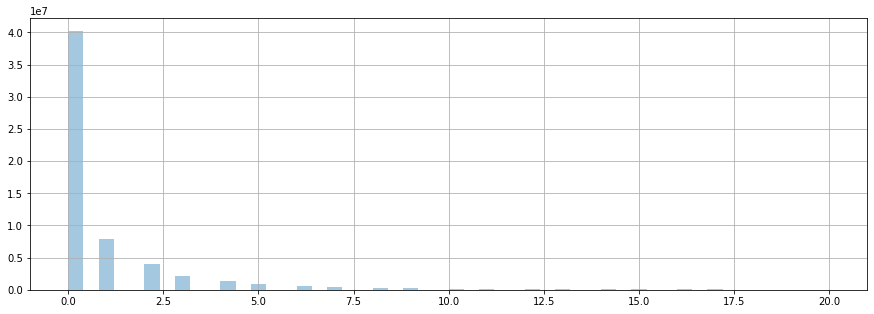

In [44]:
plt.figure(figsize=(15,5))
sns.distplot(data.query("q <= 20").q.values, kde=False)
plt.grid()
plt.show()

In [45]:
def remove_starting_zeros(dataframe):
    idxmin = dataframe.query("q > 0").index.min()
    return dataframe.loc[idxmin:, :]

In [46]:
%%time
data = (data
        .groupby(["item_id","store_id"])
        .apply(remove_starting_zeros)
        .reset_index(drop=True))

CPU times: user 4min 25s, sys: 1min 21s, total: 5min 46s
Wall time: 5min 46s


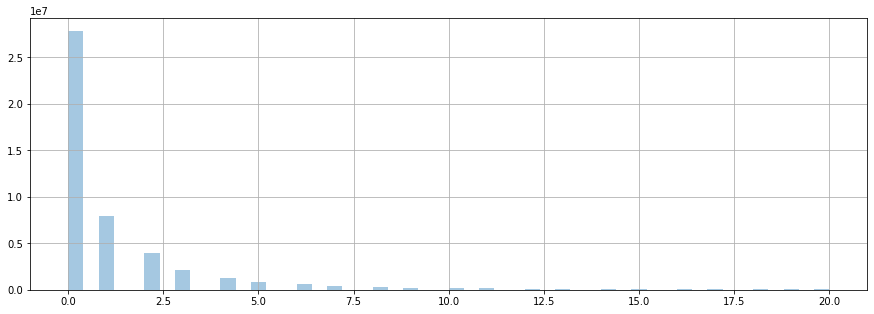

In [47]:
plt.figure(figsize=(15,5))
sns.distplot(data.query("q <= 20").q.values, kde=False)
plt.grid()
plt.show()

In [48]:
data.isnull().sum(axis=0)

ts_id                0
item_id              0
dept_id              0
cat_id               0
store_id             0
state_id             0
d                    0
q                    0
ds                   0
wm_yr_wk             0
snap_CA              0
snap_TX              0
snap_WI              0
snap_CA_cum          0
snap_TX_cum          0
snap_WI_cum          0
event_name_1         0
event_type_1         0
event_name_2         0
event_type_2         0
sell_price           0
n_prices             0
regular_price        0
price_iqr1           0
price_iqr2           0
price_min            0
price_max            0
discount             0
discount_norm        0
price_momentum_m     0
price_momentum_q     0
price_momentum_y     0
prev_christmas       0
post_christmas       0
prev_newyear         0
post_newyear         0
prev_thanksgiving    0
post_thanksgiving    0
lw_type              0
lw_day               0
prev_lw              0
post_lw              0
dtype: int64

***
## out of stock patterns

In [49]:
def find_out_of_stock(df):
    df = df.copy()
    df["no_stock_days"] = 0
    zero_mask = (df.q == 0)
    transition_mask = (zero_mask != zero_mask.shift(1))
    zero_sequences = transition_mask.cumsum()[zero_mask]
    zero_seqs_count = zero_sequences.map(zero_sequences.value_counts()).to_frame()
    df.loc[zero_seqs_count.index, "no_stock_days"] = zero_seqs_count.q.values
    return df

In [50]:
%%time
data = data.groupby(["item_id","store_id"]).apply(find_out_of_stock)

CPU times: user 4min 10s, sys: 48.8 s, total: 4min 59s
Wall time: 4min 59s


In [51]:
data.reset_index(drop=True, inplace=True)
data.drop(["d", "wm_yr_wk"], axis=1, inplace=True)
data = reduce_mem_usage(data)
gc.collect()

22

***
## frequency of sales

How frequent an item is sold in a given store

In [52]:
%%time 

sales_freq_mean = (data
                   .query("no_stock_days < 28 & q >= 1")
                   .groupby("ts_id")["ds"]
                   .apply(lambda x: (x.diff(1).mean()).total_seconds() / 86400)
                   .reset_index(name="sales_freq_mean"))

sales_freq_std = (data
                  .query("no_stock_days < 28 & q >= 1")
                  .groupby("ts_id")["ds"]
                  .apply(lambda x: (x.diff(1).std()).total_seconds() / 86400)
                  .reset_index(name="sales_freq_std"))

#sales_freq_median = (data
#                    .query("no_stock < 28 & q >= 1")
#                    .groupby("ts_id")["ds"]
#                    .apply(lambda x: (x.diff(1).median()).total_seconds() / 86400)
#                    .reset_index(name="sales_freq_median"))

#sales_freq_iqr = (data
#                   .query("no_stock < 28 & q >= 1")
#                   .groupby("ts_id")["ds"]
#                   .apply(lambda x: (x.diff(1).quantile(0.8) - x.diff(1).quantile(0.2)).total_seconds() / 86400)
#                   .reset_index(name="sales_freq_iqr"))

CPU times: user 45.2 s, sys: 12.1 s, total: 57.3 s
Wall time: 57.2 s


In [53]:
data = (data
        .merge(sales_freq_mean, how="left")
        .merge(sales_freq_std, how="left")
       )

In [54]:
data = reduce_mem_usage(data)
gc.collect()

44

***
## evaluation dataframe

***

In [55]:
calendar_columns = ["date", "wm_yr_wk", "snap_CA", "snap_TX", "snap_WI", 
                    "snap_CA_cum", "snap_TX_cum", "snap_WI_cum",
                    "event_name_1", "event_type_1", "event_name_2", "event_type_2"]

eval_dataframe = (pd.concat([make_time_range("2016-05-23", "2016-06-19", "D").assign(**row)
                             for _,row in hierarchy.iterrows()], ignore_index=True)
                  .merge(calendar.loc[:, calendar_columns],
                         how="left", left_on="ds", right_on="date")
                  .merge(sell_prices, how="left")
                  .merge(events_features, how="left", on="ds")
                  .merge(lw_features, how="left", on="ds")
                  .merge(sales_freq_mean, how="left")
                  .merge(sales_freq_std, how="left")
                  .drop(["id","date","wm_yr_wk"], axis=1)
                 )

In [56]:
#eval_dataframe["no_stock"] = np.nan
#eval_dataframe["no_stock_level"] = 0

#for i,no_stock in enumerate(no_stock_ts):
#    idx = eval_dataframe.query("ts_id in @no_stock.ts_id").index
#    eval_dataframe.loc[idx, "no_stock_level"] = i+1

In [57]:
eval_dataframe = reduce_mem_usage(eval_dataframe)

***
### Saving the dataframes

In [58]:
# training data
(data
 .to_parquet("../input/train_dataframe.parquet", index=False)
)

In [59]:
# evaluation data
(eval_dataframe
 .to_parquet("../input/eval_dataframe.parquet", index=False)
)

***